## Introduction to _"Spectral Audification"_

### 0. Set-Up

First import a load of modules

In [1]:
%matplotlib inline
%reload_ext autoreload 
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from strauss.sonification import Sonification
from strauss.sources import Events, Objects
from strauss import channels
from strauss.score import Score
from strauss.generator import Spectralizer
import IPython.display as ipd
import os
from scipy.interpolate import interp1d
import numpy as np
import pathlib
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['figure.figsize'] = (6,1)
# print(mpl.rcParams.keys())

and initialise some _STRAUSS_ objects

In [2]:
score =  Score([['A2']], 1)
generator = Spectralizer()

...and set up a function to make plots

In [3]:
def plot_spec2sound(freq, spec, soni):
    fig = plt.figure()
    fig.add_subplot(121)
    plt.fill_between(freq,spec, alpha=0.4)
    plt.plot(freq,spec)
    plt.axis('off')
    fig.add_subplot(122)
    plt.plot(soni.out_channels['0'].values[:1200])
    plt.axis('off')
    arrow = patches.FancyArrowPatch(
        (0.48,0.5),(0.52,0.5), shrinkA=0, shrinkB=0, 
        transform=fig.transFigure, color="C0", arrowstyle="-|>",
        mutation_scale=15, linewidth=2)
    fig.patches.append(arrow)
    return fig

### 1. The Approach

Here we'll explore some of the basic spectral features and how they manifest with the spectral audification approach used in the JDAViz Listener implementation.




This approach is fundamentally based on an inverse Fourier transform, where the frequencies of light are mapped onto frequencies of sound.  

In this pardigm, delta functions become sinusoids of different frequencies, which are heard as tones:

![image](images/intro_1.png)

![image](images/intro_2.png)

These combine linearly and we hear something like a _"chord"_ which tells us about the combination of lines...

![image](images/intro_3.png)

Other features, like the continuum manigest as 'spectral noise' - this is like many, many sinusoids playing at once. A constant-values continuum manifests in something like _"white noise"_ while sloped continuua can yield something _"coloured noise"_

![image](images/intro_4.png)

### 2. Examples: Single Emission Lines

In [5]:
# let's pretend this is an astronomical spectrum, between 200 and 800 nm
freqs = np.linspace(400, 750, 10000) # say, THz
zspec = np.zeros(freqs.size)

Set single values to 1 to approximate a delta function at different frequencies

In [7]:
spec1 = zspec.copy()
spec2 = zspec.copy()
spec3 = zspec.copy()

spec1[500] = 1
spec2[zspec.size//2] = 1
spec3[-500] = 1

specs = (spec1, spec2, spec3)

...and let's hear them

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


NameError: name 'patches' is not defined

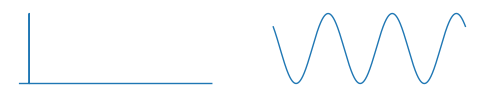

In [9]:
# Lets pick the mapping frequency range for the spectrum...
generator.modify_preset({'min_freq':100, 'max_freq':500})
data = {'spectrum':[zspec], 'pitch':[1]}
lims = {'spectrum': (0,1)}

for s in specs:
    print('='*60)
    sources = Events(data.keys())
    sources.fromdict({'spectrum':[s], 'pitch':[1]})
    sources.apply_mapping_functions(map_lims=lims)
    
    # render and play sonification!
    soni = Sonification(score, sources, generator, 'mono')
    soni.render()
    plot_spec2sound(freqs, s, soni)
    plt.show()
    soni.notebook_display(show_waveform=False)

Hear how the low frequency line results in a lower potch representation and vice versa. 

### 3. Examples: Continuua

Next, we show the effect of a continuum term...

Just trying a negative sloped, constant, and positively sloped continuum

In [ ]:
linspec = np.linspace(0,1, 10000)

spec4 = linspec**1
spec5 = linspec**0
spec6 = 1-linspec**1

specs2 = (spec4, spec5, spec6)

In [ ]:
generator.modify_preset({'min_freq':100, 'max_freq':5000})

for s in specs2:
    print('='*100)
    sources = Events(data.keys())
    sources.fromdict({'spectrum':[s], 'pitch':[1]})
    sources.apply_mapping_functions(map_lims=lims)
        
    # render and play sonification!
    soni = Sonification(score, sources, generator, 'mono')
    soni.render()
    plot_spec2sound(freqs, s, soni)
    plt.show()
    soni.notebook_display(show_waveform=False)

Hear the different timbres of these examples. I positively sloped continuum has more of a _'hiss'_ due to boosterd high-frequency power (_"treble"_) while the negative slope more of a _'rumble'_ due to low-frequency power ("_bass_")

### 4. Examples: Emission Line Widths

Line profiles may not be in the narrow ($\delta$-function-like) limit, so what is the effect of the relative line width on the sound?

Lets make some Gaussian profiles of varying width ($\sigma$)

In [ ]:
linspec = np.linspace(0,1,10000)
std = 1e-3

spec7 = np.exp(-((linspec-0.5)/std)**2)
spec8 = np.exp(-((linspec-0.5)/(std*40))**2)
spec9 = np.exp(-((linspec-0.5)/(std*80))**2)

specs3 = (spec7, spec8, spec9)

In [ ]:
generator.modify_preset({'min_freq':100, 'max_freq':1000})

for s in specs3:
    print('='*100)
    sources = Events(data.keys())
    sources.fromdict({'spectrum':[s], 'pitch':[1]})
    sources.apply_mapping_functions(map_lims=lims)
        
    # render and play sonification!
    soni = Sonification(score, sources, generator, 'mono')
    soni.render()
    plot_spec2sound(freqs, s, soni)
    plt.show()
    soni.notebook_display(show_waveform=False)

The pure tone of a narrow line gives may to a more _"intense"_, _"windy"_ or _"breathy"_ sound. Note a wider line includes a broader range of frequencies and therefore a noisier sound.  

### 5. Examples: Absorption Lines

But what about absorption? In this case the line is represent by an _absence_ of sound frequencies. This is generally a lot harder to identify - can you hear one missing frequency out of thousands playing, as opposed to one tone.

Line widths can make this more noticable - but in general this is hard... an idea is to invert the absorption features so they become emission features and therefore more perceptible.

Let's try different line-widths, including no line at all:

In [ ]:
specs3 = (spec5, 1-spec7, 1-spec8, 1-spec9**0.2)

In [ ]:
generator.modify_preset({'min_freq':100, 'max_freq':5000})

for s in specs3:
    print('='*100)
    sources = Events(data.keys())
    sources.fromdict({'spectrum':[s], 'pitch':[1]})
    sources.apply_mapping_functions(map_lims=lims)
        
    # render and play sonification!
    soni = Sonification(score, sources, generator, 'mono')
    soni.render()
    plot_spec2sound(freqs, s, soni)
    plt.show()
    soni.notebook_display(show_waveform=False)

Could you notice any differences?

### 6. Examples: Emission Lines + Continuum

How do these features combine? Again features add together linearly, so in the common scenario of emission lines and continuum together, we should hear a combination of tone and noise.

However we have to note that there is a lot of integrated power in the continuum vs the noise, so a low level of continuum can still dominate the sound, unless we process the spectra.

In [ ]:
spec10 = spec6*1e-3
spec10[spec10.size//2] = 1

spec11 = spec6*1e-2
spec11[spec10.size//2] = 1

spec12 = spec6*0.1
spec12[spec10.size//2] = 1

specs4 = (spec10, spec11, spec12)

In [ ]:
generator.modify_preset({'min_freq':100, 'max_freq':2000})

for s in specs4:
    print('='*100)
    sources = Events(data.keys())
    sources.fromdict({'spectrum':[s], 'pitch':[1]})
    sources.apply_mapping_functions(map_lims=lims)
        
    # render and play sonification!
    soni = Sonification(score, sources, generator, 'mono')
    soni.render()
    plot_spec2sound(freqs, s, soni)
    plt.show()
    soni.notebook_display(show_waveform=False)

Hear that noise is audible, even at less than a 1000th level of the peak. In the 1/10 level continuum the tone is barely audible.  This is because the integrated power in a continuum can overwhelm a very narrow line, even at a low normalisation.

Processing the continuum in some way before listening can help this scenario. If we want to boost the tone, we could either:
- fit and subtract a continuum to focus on the line alone
- boost high powers more dramatically i.e. make the spectrum _"peakier"_ or _"cuspier"_

Interestingly (ahem) this is the opposite problem we often have with raw imaging data - we often need to reduce the dynamic range to bring out low surface brightness features so we don't just have a few bright pixels. This can be done by using e.g. a log scale or a positive fractional power (e.g. `img**0.5`)

![image](images/intro_galanalogy.png)
_Reducing the dynamic range can help bring out features in astronomical imaging. For spectral audification, we often want to do the opposite_

In the case of this spectra problem, we want to boost the dynamic range, which can be acheived using a power > 1, for example, a power of 2

In [ ]:
power = 2

for s in specs4:
    print('='*100)
    sources = Events(data.keys())
    sources.fromdict({'spectrum':[pow(s, power)], 
                      'pitch':[1]})
    sources.apply_mapping_functions(map_lims=lims)
        
    # render and play sonification!
    soni = Sonification(score, sources, generator, 'mono')
    soni.render()
    plot_spec2sound(freqs, s, soni)
    plt.show()
    soni.notebook_display(show_waveform=False)

### 7. Examples: Multiple Emission Lines

Finally we'll hear these for multiple emission lines at ones. Again these combine linearly and we hear their independent tones at once

We'll also make each added line weaker each time to show how we har lines of differing strength

In [ ]:
np.random.seed(42)
choice = np.random.choice(spec13.size, size=3, replace=False).astype(int)
spec13 = spec2.copy()
spec14 = spec2.copy()
spec15 = spec2.copy()

spec13[choice[:1]] = (np.arange(1.)+2)**-2
spec14[choice[:2]] = (np.arange(2.)+2)**-2
spec15[choice] = (np.arange(3.)+2)**-2

specs5 = (spec2, spec13, spec14, spec15)

In [ ]:
generator.modify_preset({'min_freq':100, 'max_freq':800})

for s in specs5:
    print('='*100)
    sources = Events(data.keys())
    sources.fromdict({'spectrum':[s], 'pitch':[1]})
    sources.apply_mapping_functions(map_lims=lims)
        
    # render and play sonification!
    soni = Sonification(score, sources, generator, 'mono')
    soni.render()
    plot_spec2sound(freqs, s, soni)
    plt.show()
    soni.notebook_display(show_waveform=False)

Notice how we can hear even the low final tone clearly despite its low level, while the third line is a bit harder to hear distinctly as it's close to the first line. However close lines often instead manifest as a 'beating': a rapid oscillation in the volume of the tone induced by two close together tones.

### Extra: Make figures we need

In [ ]:
flg = 1
for s in (specs[0], specs5[0], specs[0]+specs5[0], specs4[-1]):
    print('='*100)
    sources = Events(data.keys())
    sources.fromdict({'spectrum':[s], 'pitch':[1]})
    sources.apply_mapping_functions(map_lims=lims)

    # render and play sonification!
    soni = Sonification(score, sources, generator, 'mono')
    soni.render()
        
    plot_spec2sound(freqs, s, soni)
    plt.savefig(f"images/intro_{flg}.png")
    plt.show()
    flg += 1